## Imports

In [1]:
import pandas as pd
import nltk
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.stats import ks_2samp
from IPython.core.display import display, HTML
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

The execution of the following cell is mandatory! This is needed to have progress bars with pandas computations.

In [2]:
tqdm.pandas()

C:\Users\Administrator\anaconda\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


If you have not yet downloaded the Treebank tokenizer for nltk, please do so by executing the following cell. You only need to do this once!

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Configuration
*language:* The language of your texts and the dictionaries you want to use.

*dictionary_dir:* The path to the directory containing the dictionaries. If you use the default directory structure, you can use `dictionaries/manual/` for dictionaries containing only manual annotated words and `dictionaries/computational/` for dictionaries containing manual and automatically extended words. Please make sure to use a '/' (slash) in the end. For example: `path/to/dictionaries/`.

*dataframe_filename:* The full path to the filename of the pandas DataFrame created in the previous step. You may use the .p extension indicating a pickled file.

*texts_results_dir:* The path to the directory used for text outputs. Please make sure to use a '/' (slash) in the end. For example: `path/to/output/`.

*plot_results_dir:* The path to the directory used for plot outputs. Please make sure to use a '/' (slash) in the end. For example: `path/to/output/`.

*plot_file_format:* The file format to use for your plots. Typically, matplotlib supports: `png`, `pdf`, `ps`, `eps` and `svg`.

*output_dataframe_filename:* The full path to the filename of the resulting pandas DataFrame including the computed sentiment. You may use the **.p** extension indicating a pickled file.

In [4]:
language = "french"
dictionary_dir = "dictionaries/computational_corrected/"
dataframe_filename = "texts_mimotext.p"
text_results_dir = "results/texts/mimotext"
plot_results_dir = "results/plots/mimotext/"
plot_file_format= "pdf"
output_dataframe_filename = "texts_with_sentiment.p"

## Directory Setup (Optional)
Creates directories according to the configuration if not already created manually.

In [5]:
if not os.path.exists(dictionary_dir):
    os.makedirs(dictionary_dir)
if not os.path.exists(text_results_dir):
    os.makedirs(text_results_dir)
if not os.path.exists(plot_results_dir):
    os.makedirs(plot_results_dir)

## Load Data

### Sentiment Dictionary

In [6]:
sentiment_dict = {}
with open("{}{}_negative.txt".format(dictionary_dir, language.lower()), "r") as fr:
    sentiment_dict["neg"] = fr.read().splitlines()
with open("{}{}_positive.txt".format(dictionary_dir, language.lower()), "r") as fr:
    sentiment_dict["pos"] = fr.read().splitlines()

print("loaded {} negative words".format(len(sentiment_dict["neg"])))
print("loaded {} positive words".format(len(sentiment_dict["pos"])))

loaded 2272 negative words
loaded 4216 positive words


### Text DataFrame

In [7]:
texts_df = pd.read_pickle(dataframe_filename)
print("loaded dataframe with {} texts and {} attributes".format(texts_df.shape[0], texts_df.shape[1] - 1))

loaded dataframe with 186 texts and 2 attributes


## Compute sentiment
This functions computes the sentiment of texts:

In [8]:
def compute_sentiment(text):
    tokens = nltk.word_tokenize(text)
    tokens = [t.lower() for t in tokens]
    num_negative = 0
    num_positive = 0
    for nw in sentiment_dict["neg"]:
        num_negative += tokens.count(nw.lower())
    for pw in sentiment_dict["pos"]:
        num_positive += tokens.count(pw.lower())
    try:
        sentiment_score = (num_positive - num_negative) / (num_positive + num_negative)
    except ZeroDivisionError:
        sentiment_score = 0
    return sentiment_score

Apply `compute_sentiment` to each text cell in the DataFrame:

In [9]:
texts_df["sentiment"] = texts_df["text"].progress_apply(compute_sentiment)

Save the DataFrame including the computing sentiment for later use:

In [10]:
texts_df.to_pickle(output_dataframe_filename)

## Sentiment Analysis

### Overall Sentiment Statistics

This prints descriptive statistics of sentiment:

In [11]:
texts_df["sentiment"].describe()

count    186.000000
mean       0.404632
std        0.113332
min        0.007037
25%        0.327772
50%        0.404710
75%        0.475697
max        0.674485
Name: sentiment, dtype: float64

#### Histogram Plot
Note that all plots are also individually saved to `plot_results_dir`.

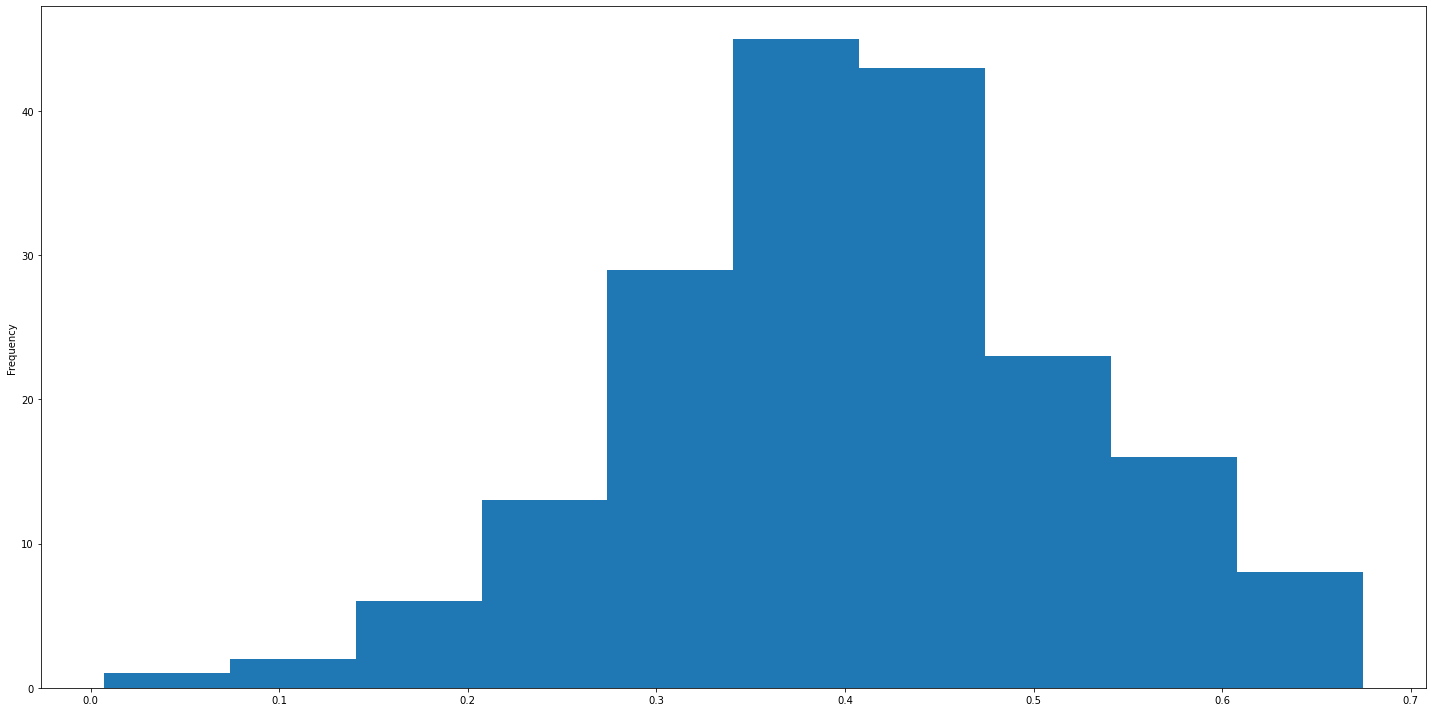

In [12]:
texts_df["sentiment"].plot(kind="hist")
plt.tight_layout()
plt.savefig("{}sentiment_histogram.{}".format(plot_results_dir, plot_file_format))
plt.show()
plt.close()

### Attribute Plots
Set the attribute you want to analyze:

In [13]:
attribute = "year"

In [14]:
texts_df.groupby(attribute)

#### Bar Plot

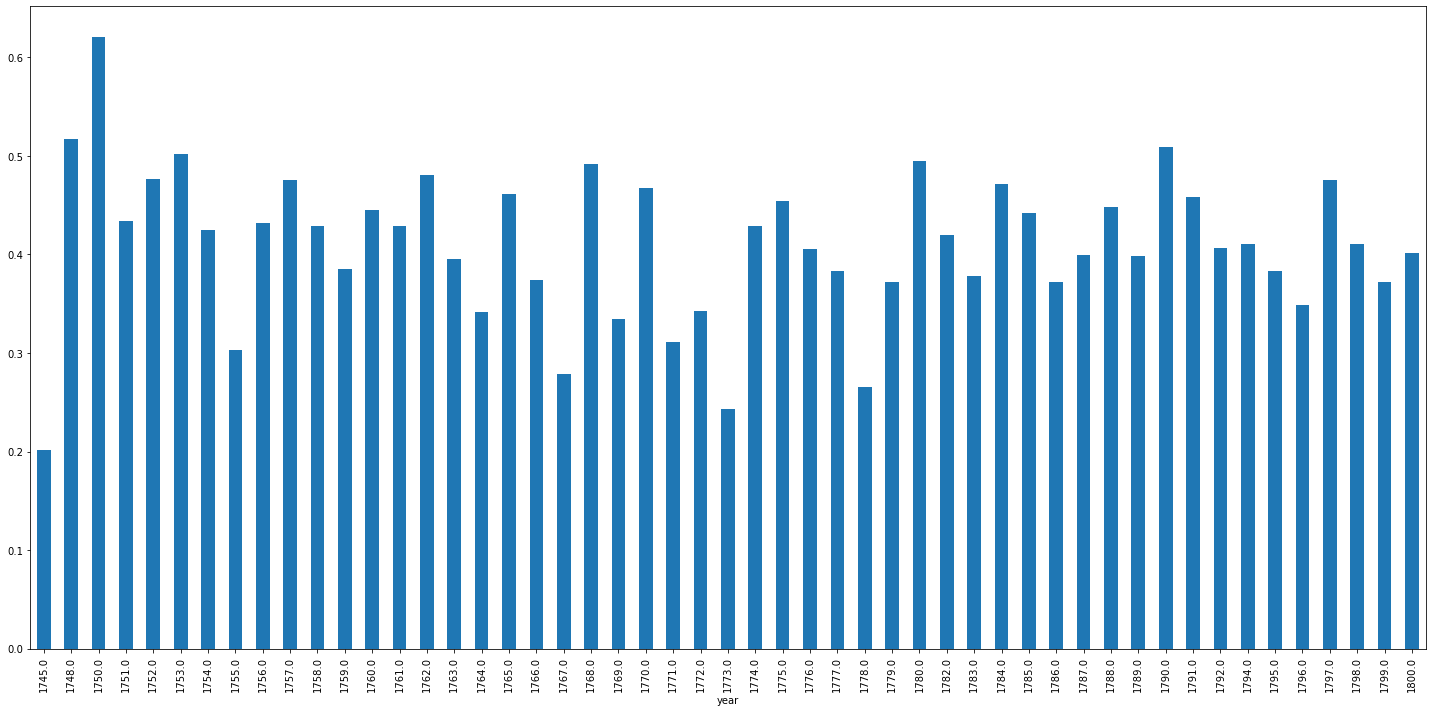

In [15]:
ax = texts_df.groupby(attribute)["sentiment"].mean().plot(kind="bar")
plt.tight_layout()
plt.savefig("{}{}_bar_plot.{}".format(plot_results_dir, attribute, plot_file_format))
plt.show()
plt.close()

#### Box Plot

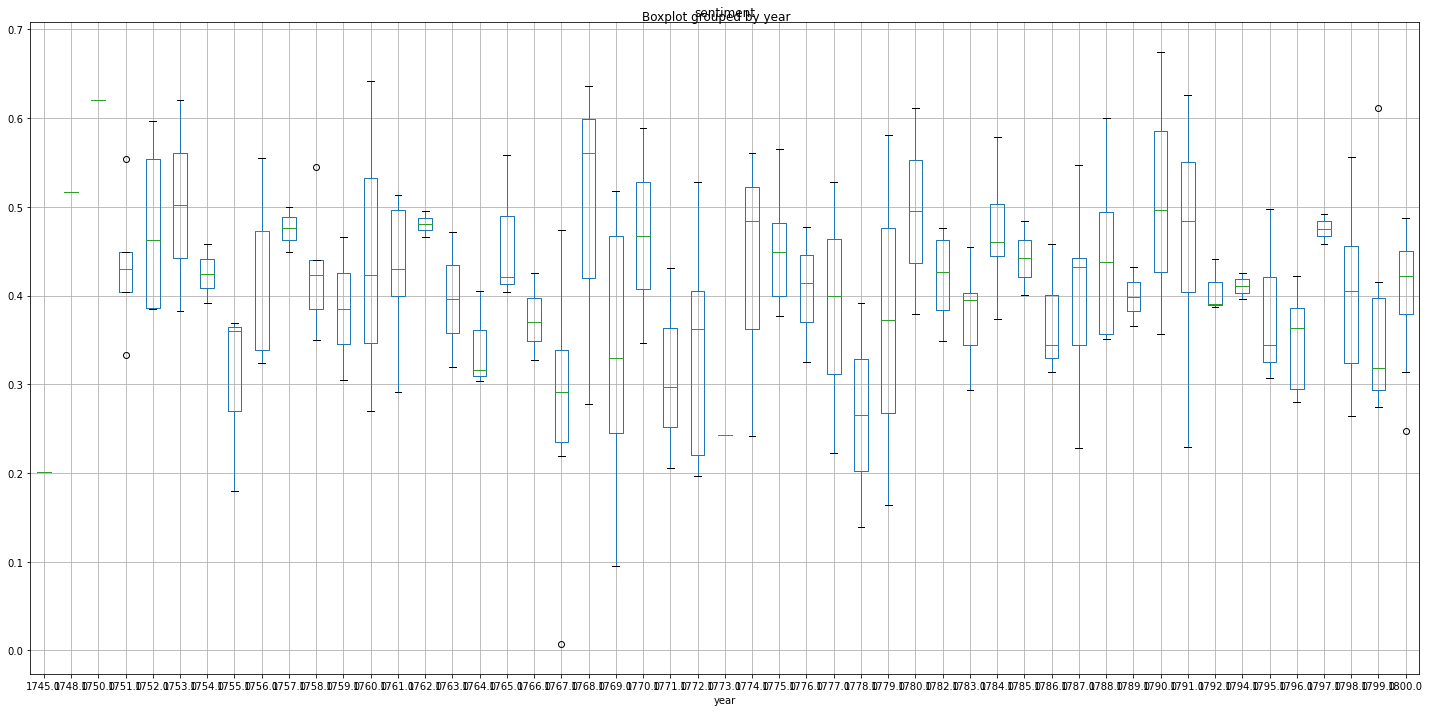

In [16]:
texts_df.boxplot("sentiment", by=attribute)
plt.tight_layout()
plt.savefig("{}{}_box_plot.{}".format(plot_results_dir, attribute, plot_file_format))
plt.show()
plt.close()

#### Line Plot

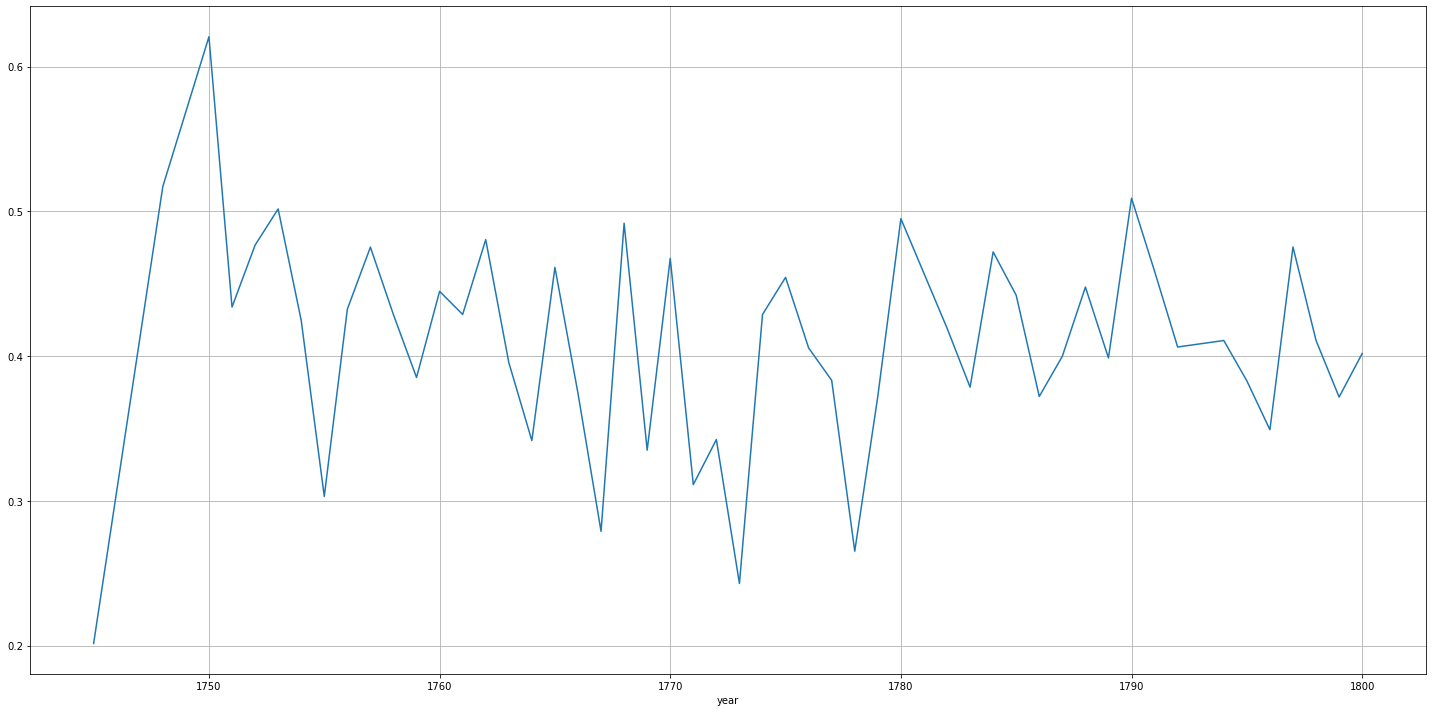

In [17]:
texts_df.groupby(attribute)["sentiment"].mean().plot(kind="line")
plt.tight_layout()
plt.savefig("{}{}_line_plot.{}".format(plot_results_dir, attribute, plot_file_format))
plt.grid()
plt.show()
plt.close()

#### Seaborn Lineplot
Seaborn `lineplot` ([documentation](https://seaborn.pydata.org/generated/seaborn.lineplot.html)) allows to separate attributes very easily using the `hue` parameter.

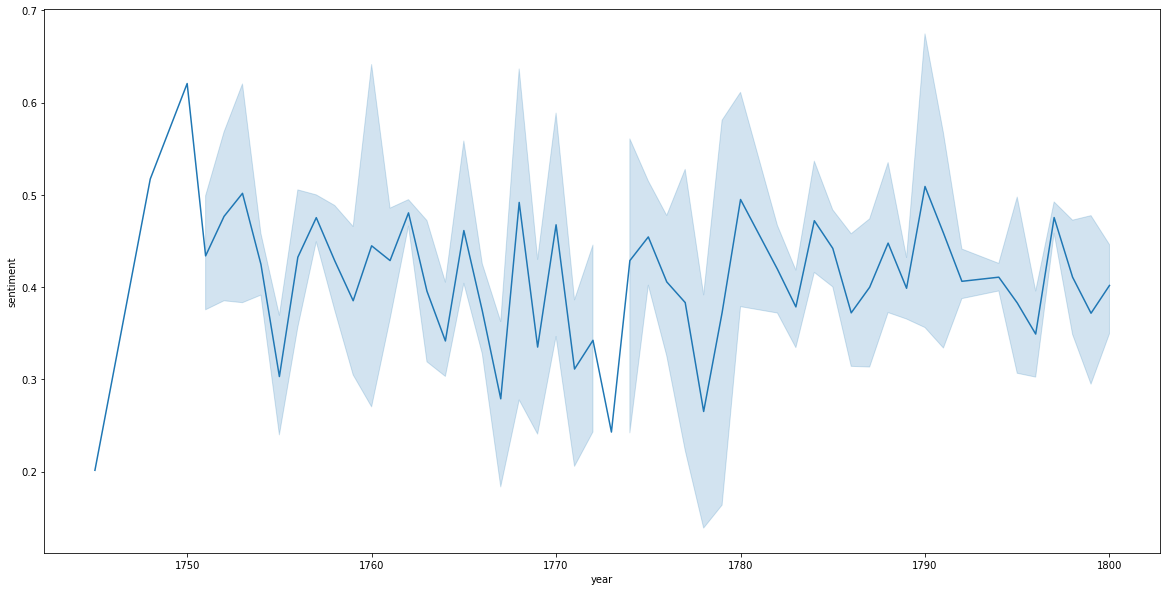

In [18]:
sns.lineplot(data=texts_df, x=attribute, y="sentiment")

### Individual Text Analysis
Set the filename of the individual text you want to analyze:

In [19]:
filename = "Bellin_Nuit.txt"

#### Sentiment Development

The next cell allows you to automalitcally partition text into cunks and compute sentiment seperately for each chunk.
Please set `num_chunks` to the number of chunks you want to analyze.

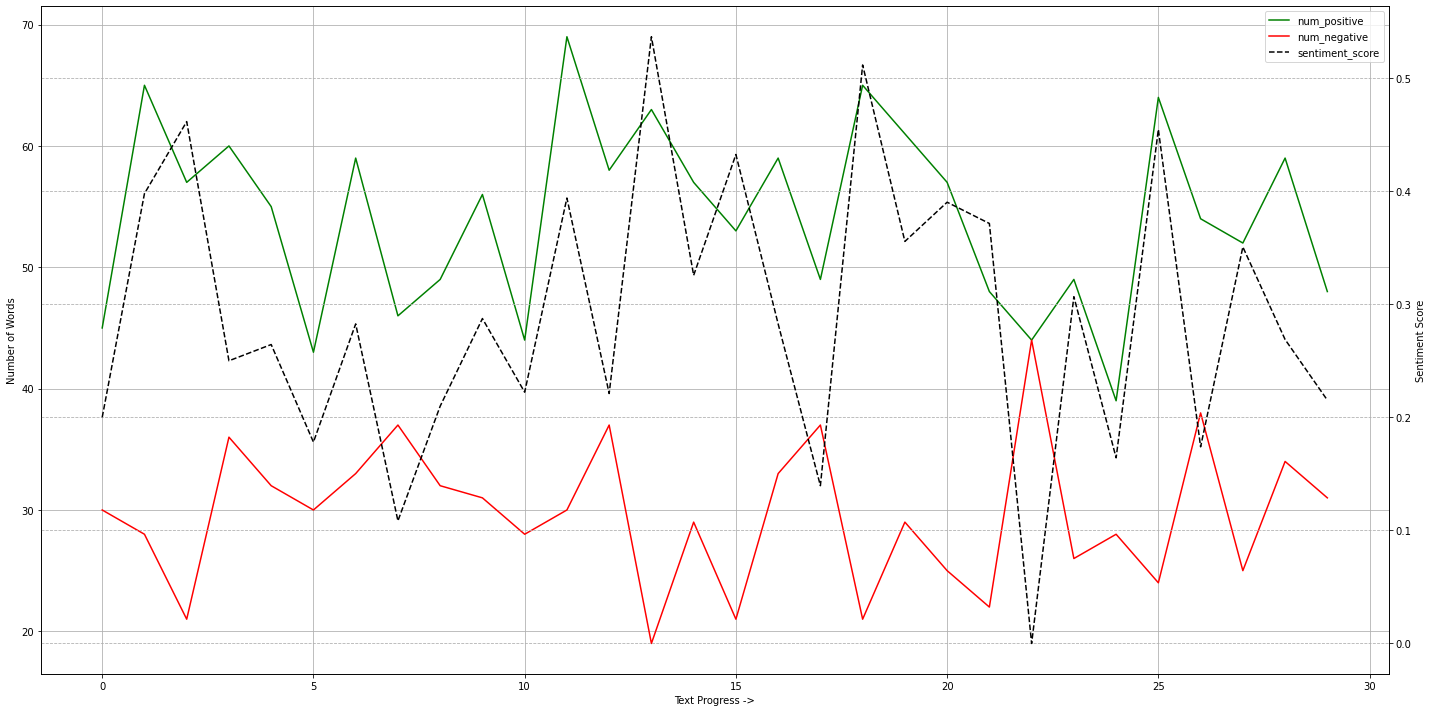

In [20]:
num_chunks = 30
tokens = nltk.word_tokenize(texts_df.loc[filename, "text"])

chunks = []

for i in range(0, num_chunks):
    chunks.append(tokens[i::num_chunks])

distant_results = []
for c in chunks:
    num_positive = 0
    num_negative = 0
    for nw in sentiment_dict["neg"]:
        num_negative += c.count(nw.lower())
    for pw in sentiment_dict["pos"]:
        num_positive += c.count(pw.lower())
    try:
        sentiment_score = (num_positive - num_negative) / (num_positive + num_negative)
    except ZeroDivisionError:
        sentiment_score = 0
    distant_results.append({"num_positive": num_positive, "num_negative": num_negative, "sentiment_score": sentiment_score})

distant_results_df = pd.DataFrame(distant_results)

lst_pal = {"num_positive": "g-", "num_negative": "r-", "sentiment_score": "k--"}

ax1 = distant_results_df[["num_positive", "num_negative"]].plot(style=lst_pal, legend=False)
ax1.set_xlabel("Text Progress ->")
ax1.set_ylabel("Number of Words")

ax2 = distant_results_df["sentiment_score"].plot(secondary_y=True, style=lst_pal)
ax2.set_ylabel("Sentiment Score")

ax1.grid()
ax2.grid(linestyle="--")

handles,labels = [],[]
for ax in [ax1, ax2]:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles, labels)
plt.tight_layout()
plt.savefig("{}{}_distant.{}".format(plot_results_dir, filename.replace(".", "_"), plot_file_format))
plt.show()
plt.close()

#### Sentiment Words Highlighting
The next cell highlights all the words conveying a sentiment in your individual text file. This is also saved to `texts_results_dir` as an *.html* file for later use.

In [21]:
text_to_print = texts_df.loc[filename, "text"]
for nw in sentiment_dict["neg"]:
    if nw in text_to_print and nw not in ["span", "style", "color", "font", "size"]:
        text_to_print = re.sub(r"\b{}\b".format(nw), r"<span style='color:#E74C3C; font-size:20pt'><b>{}</b></span>".format(nw), text_to_print)
        
for pw in sentiment_dict["pos"]:
    if pw in text_to_print and pw not in ["span", "style", "color", "font", "size"]:
        text_to_print = re.sub(r"\b{}\b".format(pw), r"<span style='color:#27AE60; font-size:20pt'><b>{}</b></span>".format(pw), text_to_print)

with open("{}{}.html".format(text_results_dir, ".".join(filename.split(".")[:-1])), "w") as outfile:
    outfile.write(text_to_print)
HTML(text_to_print)

In [22]:
save.HTML(text_to_print)


NameError: name 'save' is not defined

### Hypothesis Test Example 

The following two-sample Kolmogorov-Smirnov has the null hypothesis that two samples are drawn from the same distribution (i.e., the sentiment is indentical for both). If the resulting p-value is smaller than, for example, the commonly used significance level 0.05, we can reject the null hypothesis. This would suggest that there are significant differences in sentiment between the two distributions. We now compare the two italian periodicals using `ks_2samp` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html)) from scipy. Please make sure that you set `language = italian` and that you loaded the correct texts as well as sentiment dictionaries before executing this cell. First we separate the two disttributions:

In [ ]:
earlieryear = texts_df[texts_df["year"] == 1751]["sentiment"]
lateryear = texts_df[texts_df["year"] == 1764 ]["sentiment"]

In [ ]:
earlieryear.describe()

In [ ]:
lateryear.describe()

And then we conduct our hypothesis test:

In [ ]:
statistic, pvalue = ks_2samp(abbes_voyage, voltaire_candide)
print("pvalue:", pvalue)

Since 0.28 > 0.05 (our significance level) we cannot reject our null hypothesis and, thus, the difference in sentiment between the two periodicals is non-significant.

# Reference

Koncar, P., Druml, L., Ertler, K.-D., Fuchs, A., Geiger, B. C., Glatz, C., Hobisch, E., Mayer, P., Saric, S., Scholger, M. & Voelkl, Y. (2021) A Sentiment Tool Chain for Languages of the 18th Century. https://github.com/philkon/sentiment-tool-chai
